# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="C:/Users/User/deep-reinforcement-learning/p3_collab-compet/Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Neural Network 
- Actor (Two Hidden Layers)
  - First Layer: Linear(state size,240) -> BatchNorm -> ReLu
  - Second Layer: Linear(240,240) -> BatchNorm -> ReLU
  - Output: Linear(240,action size) -> Tanh
  
- Critic (Two Hidden Layers)
  - First Layer: Linear(state size*2,240) -> ReLu
  - Second Layer: Linear(240+(action size*2),240) -> ReLU
  - Output: Linear(330,1)

In [4]:
####### Model MADDPG #########

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import copy
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import pandas as pd


import torch.optim as optim

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=240, fc2_units=240):
        """Initialize parameters and build m/odel.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc1_bn=nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc2_bn=nn.BatchNorm1d(fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x=self.fc1(state)
        x = F.relu(self.fc1_bn(x))
        x=self.fc2(x)
        x = F.relu(self.fc2_bn(x))
        x=F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=240, fc2_units=240):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size*2, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+(action_size*2), fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### 3. Hyperparameters
The hyperparameters are listed as below:

- Buffer size: 1000000
- Batch size : 256
- Gamma : 0.99
- lr (Learning rate for both actor and critic) : 4e-4
- Update Step (Number of steps before updating the weights) : 4
- Number of steps to learn: 1
- Tau : 1e-3
- Weight decay : 0



In [5]:
#########  Agent MADDPG #########

BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 256        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3             # for soft update of target parameters
LR_ACTOR = 4e-4         # learning rate of the actor 
LR_CRITIC = 4e-4        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
learn_step_=4

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size,agent_number, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.learn_step=0
        self.agent_number=agent_number
        
        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)
        
        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def step(self, state, action, reward, next_state, done,learntimes=1):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        state_add=state.reshape(1,-1)
        action_add=action.reshape(1,-1)
        reward_add=reward
        next_state_add=next_state.reshape(1,-1)
        done_add=done
        self.memory.add(state_add, action_add, reward_add, next_state_add, done_add)
        self.learn_step=(self.learn_step+1)%learn_step_
        
        if len(self.memory) > BATCH_SIZE:
         if self.learn_step==0:
            experiences = self.memory.sample()
            for i in range(learntimes):
             self.learn(experiences, GAMMA)
             self.soft_update(self.critic_local, self.critic_target, TAU)
             self.soft_update(self.actor_local, self.actor_target, TAU)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""

        state=state.reshape(1,-1)
        
        if self.agent_number==0:
         state = torch.from_numpy(state[:,:24]).float().to(device)
        else:
         state = torch.from_numpy(state[:,24:]).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action=self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action+= self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        
        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        if self.agent_number==0:
         actions_next_first = self.actor_target(next_states[:,:24])
         actions_next_second = actions[:,2:]
        else:
         actions_next_first = actions[:,:2]
         actions_next_second = self.actor_target(next_states[:,24:])
        actions_next=torch.cat((actions_next_first,actions_next_second),dim=1)
        Q_targets_next = self.critic_target(next_states,actions_next)

        # Compute Q targets for current states (y_i)
        
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        
        # Compute critic loss
        
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        if self.agent_number==0:
         actions_pred_first = self.actor_local(states[:,:24])
         actions_pred_second = actions[:,2:]
        else:
         actions_pred_first = actions[:,:2]
         actions_pred_second = self.actor_local(states[:,24:])
        actions_pred=torch.cat((actions_pred_first,actions_pred_second),dim=1)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.size=size
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### 4. Training

- Number of Episodes: 6000
- Number of Agents: 2


In [6]:
total_agent=2
agent0 = Agent(state_size=24, action_size=2,agent_number=0, random_seed=6)
agent1 = Agent(state_size=24,action_size=2,agent_number=1,random_seed=6)

def maddpg(n_episodes=6000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        score = np.zeros(total_agent)
        while True:
            action0 = agent0.act(state)
            action1= agent1.act(state)
            action=np.concatenate((action0, action1), axis=0)
            env_info =env.step(action)[brain_name] 
            next_state = env_info.vector_observations  
            reward = env_info.rewards
            done = env_info.local_done
            agent0.step(state,action,reward[0],next_state,done[0])
            agent1.step(state,action,reward[1],next_state,done[1])
            state = next_state
            score += reward
            if np.any(done):
                break 
        scores_deque.append(np.max(score))
        scores.append(np.max(score))
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(agent0.actor_local.state_dict(), 'checkpoint_actor_0.pth')
        torch.save(agent0.critic_local.state_dict(), 'checkpoint_critic_0.pth')
        torch.save(agent1.actor_local.state_dict(), 'checkpoint_actor_1.pth')
        torch.save(agent1.critic_local.state_dict(), 'checkpoint_critic_1.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
    return scores

scores = maddpg()



Episode 100	Average Score: 0.00
Episode 200	Average Score: 0.00
Episode 300	Average Score: 0.01
Episode 400	Average Score: 0.00
Episode 500	Average Score: 0.00
Episode 600	Average Score: 0.00
Episode 700	Average Score: 0.00
Episode 800	Average Score: 0.00
Episode 900	Average Score: 0.00
Episode 1000	Average Score: 0.00
Episode 1100	Average Score: 0.00
Episode 1200	Average Score: 0.00
Episode 1300	Average Score: 0.00
Episode 1400	Average Score: 0.01
Episode 1500	Average Score: 0.00
Episode 1600	Average Score: 0.00
Episode 1700	Average Score: 0.02
Episode 1800	Average Score: 0.01
Episode 1900	Average Score: 0.02
Episode 2000	Average Score: 0.01
Episode 2100	Average Score: 0.01
Episode 2200	Average Score: 0.02
Episode 2300	Average Score: 0.01
Episode 2400	Average Score: 0.03
Episode 2500	Average Score: 0.03
Episode 2600	Average Score: 0.03
Episode 2700	Average Score: 0.04
Episode 2800	Average Score: 0.04
Episode 2900	Average Score: 0.05
Episode 3000	Average Score: 0.05
Episode 3100	Averag

### 5. Plot Reward

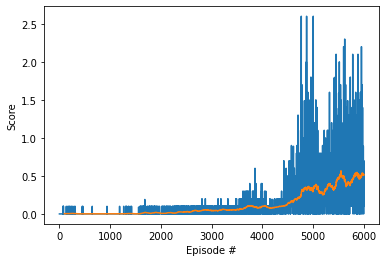

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.plot(np.arange(100,len(scores)),pd.Series(scores).rolling(100).mean()[100:])
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 6. Future Works

Try solving the task by implement method as below:
- Montecarlo Tree Search
- Optimize the code